In [1]:
import pandas as pd

logs_df = pd.read_csv("tranning_logs.csv")
logs_df.head()

,timestamp,source,log_message,target_label,complexity
0,2025-06-27 07:20:25,ModernCRM,nova.osapi_compute.wsgi.server [req-b9718cd8-f...,HTTP Status,bert
1,1/14/2025 23:07,ModernCRM,Email service experiencing issues with sending,Critical Error,bert
2,1/17/2025 1:29,AnalyticsEngine,Unauthorized access to data was attempted,Security Alert,bert
3,2025-07-12 00:24:16,ModernHR,nova.osapi_compute.wsgi.server [req-4895c258-b...,HTTP Status,bert
4,2025-06-02 18:25:23,BillingSystem,nova.osapi_compute.wsgi.server [req-ee8bc8ba-9...,HTTP Status,bert


In [2]:
logs_df.drop(columns=["complexity"], inplace=True)
logs_df.head()

,timestamp,source,log_message,target_label
0,2025-06-27 07:20:25,ModernCRM,nova.osapi_compute.wsgi.server [req-b9718cd8-f...,HTTP Status
1,1/14/2025 23:07,ModernCRM,Email service experiencing issues with sending,Critical Error
2,1/17/2025 1:29,AnalyticsEngine,Unauthorized access to data was attempted,Security Alert
3,2025-07-12 00:24:16,ModernHR,nova.osapi_compute.wsgi.server [req-4895c258-b...,HTTP Status
4,2025-06-02 18:25:23,BillingSystem,nova.osapi_compute.wsgi.server [req-ee8bc8ba-9...,HTTP Status


In [3]:
logs_df["target_label"].value_counts()

target_label
HTTP Status            1017
Security Alert          371
System Notification     356
Error                   177
Resource Usage          177
Critical Error          161
User Action             144
Workflow Error            4
Deprecation Warning       3
Name: count, dtype: int64

In [4]:
logs_df["source"].value_counts()

source
ThirdPartyAPI      496
ModernHR           492
BillingSystem      479
AnalyticsEngine    471
ModernCRM          465
LegacyCRM            7
Name: count, dtype: int64

In [5]:
logs_df[logs_df["target_label"] == "Workflow Error"]["log_message"].head()

60      Lead conversion failed for prospect ID 7842 du...
377     Customer follow-up process for lead ID 5621 fa...
1325    Escalation rule execution failed for ticket ID...
2217    Task assignment for TeamID 3425 could not comp...
Name: log_message, dtype: str

In [6]:
from sentence_transformers import SentenceTransformer
from sklearn.cluster import DBSCAN
import numpy as np

model = SentenceTransformer('all-MiniLM-L6-v2')

embeddings = model.encode(logs_df['log_message'].tolist())
embeddings[:2]

c:\Users\tamma\Development\Hybrid_log_classification_system\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Loading weights: 100%|██████████| 103/103 [00:00<00:00, 463.58it/s, Materializing param=pooler.dense.weight]                             
BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


array([[-1.02939621e-01,  3.35459262e-02, -2.20260601e-02,
         1.55105593e-03, -9.86920949e-03, -1.78956255e-01,
        -6.34409785e-02, -6.01761676e-02,  2.81108841e-02,
         5.99620454e-02, -1.72618646e-02,  1.43367471e-03,
        -1.49560004e-01,  3.15285777e-03, -5.66031076e-02,
         2.71685384e-02, -1.49890380e-02, -3.54037546e-02,
        -3.62936258e-02, -1.45410234e-02, -5.61493542e-03,
         8.75539109e-02,  4.55120429e-02,  2.50963680e-02,
         1.00187706e-02,  1.24267014e-02, -1.39923617e-01,
         7.68696442e-02,  3.14095207e-02, -4.15248703e-03,
         4.36902680e-02,  1.71250310e-02, -8.00951496e-02,
         5.74005917e-02,  1.89091805e-02,  8.55262280e-02,
         3.96399237e-02, -1.34371832e-01, -1.44364929e-03,
         3.06707853e-03,  1.76854029e-01,  4.44886740e-03,
        -1.69275180e-02,  2.24266723e-02, -4.35049348e-02,
         6.09028572e-03, -9.98169184e-03, -6.23973049e-02,
         1.07372776e-02, -6.04895549e-03, -7.14660808e-0

In [9]:
dbscan = DBSCAN(eps=0.5, min_samples=5 , metric='cosine')
clusters = dbscan.fit_predict(embeddings)

logs_df['cluster'] = clusters

print(f"Number of clusters: {len(set(clusters)) - (1 if -1 in clusters else 0)}")
print(logs_df[['log_message', 'cluster']].head(10))

Number of clusters: 5
                                         log_message  cluster
0  nova.osapi_compute.wsgi.server [req-b9718cd8-f...        0
1     Email service experiencing issues with sending        1
2          Unauthorized access to data was attempted        1
3  nova.osapi_compute.wsgi.server [req-4895c258-b...        0
4  nova.osapi_compute.wsgi.server [req-ee8bc8ba-9...        0
5  nova.osapi_compute.wsgi.server [req-f0bffbc3-5...        0
6          Shard 6 replication task ended in failure        1
7  File data_6169.csv uploaded successfully by us...        2
8  nova.compute.claims [req-a07ac654-8e81-416d-bf...        0
9  nova.osapi_compute.wsgi.server [req-2bf7cfee-a...        0


In [11]:
logs_df["cluster"].value_counts()   

cluster
 0    1194
 1     902
 3     197
 4      58
 2      53
-1       6
Name: count, dtype: int64

In [13]:
logs_df[logs_df["cluster"] == 1].head(10)

,timestamp,source,log_message,target_label,cluster
1,1/14/2025 23:07,ModernCRM,Email service experiencing issues with sending,Critical Error,1
2,1/17/2025 1:29,AnalyticsEngine,Unauthorized access to data was attempted,Security Alert,1
6,3/1/2025 19:14,ModernHR,Shard 6 replication task ended in failure,Error,1
10,8/9/2025 18:58,ModernCRM,Email server encountered a sending fault,Error,1
11,6/15/2025 11:44,ModernHR,Critical system unit error: unit ID Component55,Critical Error,1
13,8/4/2025 19:57,ThirdPartyAPI,Multiple bad login attempts detected on user 8...,Security Alert,1
18,2/22/2025 17:49,ModernCRM,Account with ID 5351 created by User634.,User Action,1
27,9/24/2025 19:57,ThirdPartyAPI,User User685 logged out.,User Action,1
29,3/10/2025 23:11,AnalyticsEngine,Alert: brute force login attempt from 192.168....,Security Alert,1
32,5/29/2025 7:36,ModernCRM,Detection of multiple disk faults in RAID setup,Critical Error,1


In [7]:
dbscan = DBSCAN(eps=0.2, min_samples=1 , metric='cosine')
clusters = dbscan.fit_predict(embeddings)

logs_df['cluster'] = clusters

print(f"Number of clusters: {len(set(clusters)) - (1 if -1 in clusters else 0)}")
print(logs_df[['log_message', 'cluster']].head(10))

Number of clusters: 136
                                         log_message  cluster
0  nova.osapi_compute.wsgi.server [req-b9718cd8-f...        0
1     Email service experiencing issues with sending        1
2          Unauthorized access to data was attempted        2
3  nova.osapi_compute.wsgi.server [req-4895c258-b...        0
4  nova.osapi_compute.wsgi.server [req-ee8bc8ba-9...        0
5  nova.osapi_compute.wsgi.server [req-f0bffbc3-5...        0
6          Shard 6 replication task ended in failure        3
7  File data_6169.csv uploaded successfully by us...        4
8  nova.compute.claims [req-a07ac654-8e81-416d-bf...        5
9  nova.osapi_compute.wsgi.server [req-2bf7cfee-a...        0


In [8]:
logs_df["cluster"].value_counts()  

cluster
0      1017
5       147
11      100
13       86
7        60
       ... 
131       1
132       1
133       1
134       1
135       1
Name: count, Length: 136, dtype: int64

In [9]:
logs_df[logs_df["cluster"] == 1].head(10)

,timestamp,source,log_message,target_label,cluster
1,1/14/2025 23:07,ModernCRM,Email service experiencing issues with sending,Critical Error,1
10,8/9/2025 18:58,ModernCRM,Email server encountered a sending fault,Error,1
217,1/22/2025 5:45,BillingSystem,Mail service encountered a delivery glitch,Error,1
248,5/2/2025 23:04,ModernHR,Service disruption caused by email sending error,Critical Error,1
265,3/30/2025 23:53,ModernCRM,Email system had a problem sending emails,Error,1
361,11/19/2025 23:06,BillingSystem,Email service experienced a sending issue,Error,1
450,10/27/2025 5:59,ThirdPartyAPI,Email delivery system encountered an error,Error,1
477,12/2/2025 10:30,AnalyticsEngine,Email transmission error caused service impact,Critical Error,1
570,11/7/2025 18:08,ThirdPartyAPI,Email service impacted by sending failure,Critical Error,1
678,4/28/2025 15:13,AnalyticsEngine,Email delivery problem affected system,Critical Error,1


In [10]:
# Find clusters with more than 10 values
prominent_clusters = logs_df["cluster"].value_counts()
prominent_clusters = prominent_clusters[prominent_clusters > 10]

print("Prominent clusters (more than 100 values):")
print(prominent_clusters)

Prominent clusters (more than 100 values):
cluster
0     1017
5      147
11     100
13      86
7       60
8       60
21      58
3       57
4       53
17      52
6       51
32      51
16      48
20      48
9       44
1       39
10      30
34      25
14      20
52      20
53      20
18      17
25      13
42      13
59      12
26      11
Name: count, dtype: int64


In [11]:
for cluster_id in prominent_clusters.index:
    print(f"\n{'='*80}")
    print(f"Cluster {cluster_id} ({prominent_clusters[cluster_id]} logs)")
    print(f"{'='*80}")
    print(logs_df[logs_df["cluster"] == cluster_id][['log_message', 'target_label']].head(10))


Cluster 0 (1017 logs)
                                          log_message target_label
0   nova.osapi_compute.wsgi.server [req-b9718cd8-f...  HTTP Status
3   nova.osapi_compute.wsgi.server [req-4895c258-b...  HTTP Status
4   nova.osapi_compute.wsgi.server [req-ee8bc8ba-9...  HTTP Status
5   nova.osapi_compute.wsgi.server [req-f0bffbc3-5...  HTTP Status
9   nova.osapi_compute.wsgi.server [req-2bf7cfee-a...  HTTP Status
12  nova.osapi_compute.wsgi.server [req-d4f8d0c2-4...  HTTP Status
16  nova.osapi_compute.wsgi.server [req-6fe0e366-f...  HTTP Status
17  nova.osapi_compute.wsgi.server [req-5f1c2027-e...  HTTP Status
19  nova.osapi_compute.wsgi.server [req-945d1f31-a...  HTTP Status
20  nova.osapi_compute.wsgi.server [req-033d97b9-6...  HTTP Status

Cluster 5 (147 logs)
                                           log_message    target_label
8    nova.compute.claims [req-a07ac654-8e81-416d-bf...  Resource Usage
26   nova.compute.claims [req-d6986b54-3735-4a42-90...  Resource Usage
40   

In [12]:
regex_patterns = {
    'HTTP Status': [
        r'^nova\.osapi_compute\.wsgi\.server.*'
    ],
    'Resource Usage': [
        r'^nova\.compute\.(claims|resource_tracker).*'
    ],
    'User Action': [
        r'^User User\d+ logged (in|out)\.',
        r'^Account with ID \d+ created by User\d+\.'
    ],
    'System Notification': [
        r'^Backup (started|ended|completed).*',
        r'^System updated to version [\d\.]+',
        r'^File .* uploaded successfully by user.*',
        r'^Disk cleanup completed successfully\.',
        r'^System reboot initiated by user.*'
    ],
    'Security Alert': [
        r'.*(Multiple|Repeated) (bad|failed|incorrect) login.*',
        r'^(Denied|Unauthorized|Invalid) login attempt.*',
        r'.*unauthorized API (access|request).*',
        r'.*(suspicious activity|compromised).*server.*',
        r'.*privilege escalation.*'
    ],
    'Critical Error': [
        r'^(Critical|Essential) system (unit|component|part) (error|malfunction|failure).*',
        r'^RAID array .* (multiple disk failures|disk crashes).*',
        r'.*kernel (panic|failure|malfunction).*',
        r'^System configuration (is no longer valid|is corrupted|failure).*'
    ],
    'Error': [
        r'.*(replication|synchronization) task failed.*shard.*',
        r'^Email service.*(experiencing issues|encountered a fault|failure).*',
        r'.*SSL certificate (validation|invalid).*',
        r'.*(Invalid|Input) (data )?format (mismatch|issue).*'
    ]
}

import re

def classify_log_message(log_message):
    for label, patterns in regex_patterns.items():
        for pattern in patterns:
            if re.match(pattern, log_message):
                return label
    return 'Unknown'



In [13]:
test_log = "nova.osapi_compute.wsgi.server Starting server on port 8774"
print(f"Label: {classify_log_message(test_log)}")

Label: HTTP Status


In [14]:
logs_df['regex_labels'] = logs_df['log_message'].apply(classify_log_message)

In [15]:
logs_df.head()

,timestamp,source,log_message,target_label,cluster,regex_labels
0,2025-06-27 07:20:25,ModernCRM,nova.osapi_compute.wsgi.server [req-b9718cd8-f...,HTTP Status,0,HTTP Status
1,1/14/2025 23:07,ModernCRM,Email service experiencing issues with sending,Critical Error,1,Error
2,1/17/2025 1:29,AnalyticsEngine,Unauthorized access to data was attempted,Security Alert,2,Unknown
3,2025-07-12 00:24:16,ModernHR,nova.osapi_compute.wsgi.server [req-4895c258-b...,HTTP Status,0,HTTP Status
4,2025-06-02 18:25:23,BillingSystem,nova.osapi_compute.wsgi.server [req-ee8bc8ba-9...,HTTP Status,0,HTTP Status


In [16]:
regex_unknown_df = logs_df[logs_df['regex_labels'] == 'Unknown'].copy()
print(f"Unknown regex labels: {len(regex_unknown_df)}")
regex_unknown_df.head()

Unknown regex labels: 847


,timestamp,source,log_message,target_label,cluster,regex_labels
2,1/17/2025 1:29,AnalyticsEngine,Unauthorized access to data was attempted,Security Alert,2,Unknown
6,3/1/2025 19:14,ModernHR,Shard 6 replication task ended in failure,Error,3,Unknown
10,8/9/2025 18:58,ModernCRM,Email server encountered a sending fault,Error,1,Unknown
29,3/10/2025 23:11,AnalyticsEngine,Alert: brute force login attempt from 192.168....,Security Alert,12,Unknown
31,2025-10-28 00:49:44,ModernCRM,"nova.metadata.wsgi.server [-] 10.11.21.138,10....",HTTP Status,0,Unknown


In [17]:
logs_df.shape

(2410, 6)

In [32]:
2410 - 847 

1563

In [18]:
regex_known_df = logs_df[logs_df['regex_labels'] != 'Unknown'].copy()
regex_known_df.head()

,timestamp,source,log_message,target_label,cluster,regex_labels
0,2025-06-27 07:20:25,ModernCRM,nova.osapi_compute.wsgi.server [req-b9718cd8-f...,HTTP Status,0,HTTP Status
1,1/14/2025 23:07,ModernCRM,Email service experiencing issues with sending,Critical Error,1,Error
3,2025-07-12 00:24:16,ModernHR,nova.osapi_compute.wsgi.server [req-4895c258-b...,HTTP Status,0,HTTP Status
4,2025-06-02 18:25:23,BillingSystem,nova.osapi_compute.wsgi.server [req-ee8bc8ba-9...,HTTP Status,0,HTTP Status
5,2025-10-09 10:30:31,ModernHR,nova.osapi_compute.wsgi.server [req-f0bffbc3-5...,HTTP Status,0,HTTP Status


In [19]:
from sklearn.metrics import accuracy_score, classification_report
import pandas as pd

y_true = regex_known_df['target_label']
y_pred = regex_known_df['regex_labels']

acc = accuracy_score(y_true, y_pred)
print(f"Accuracy: {acc:.4f} ({acc*100:.2f}%)\n")

print("Classification report:")
print(classification_report(y_true, y_pred, zero_division=0))


Accuracy: 0.9987 (99.87%)

Classification report:
                     precision    recall  f1-score   support

     Critical Error       1.00      0.91      0.95        23
              Error       0.82      1.00      0.90         9
        HTTP Status       1.00      1.00      1.00       809
     Resource Usage       1.00      1.00      1.00       177
     Security Alert       1.00      1.00      1.00        45
System Notification       1.00      1.00      1.00       356
        User Action       1.00      1.00      1.00       144

           accuracy                           1.00      1563
          macro avg       0.97      0.99      0.98      1563
       weighted avg       1.00      1.00      1.00      1563



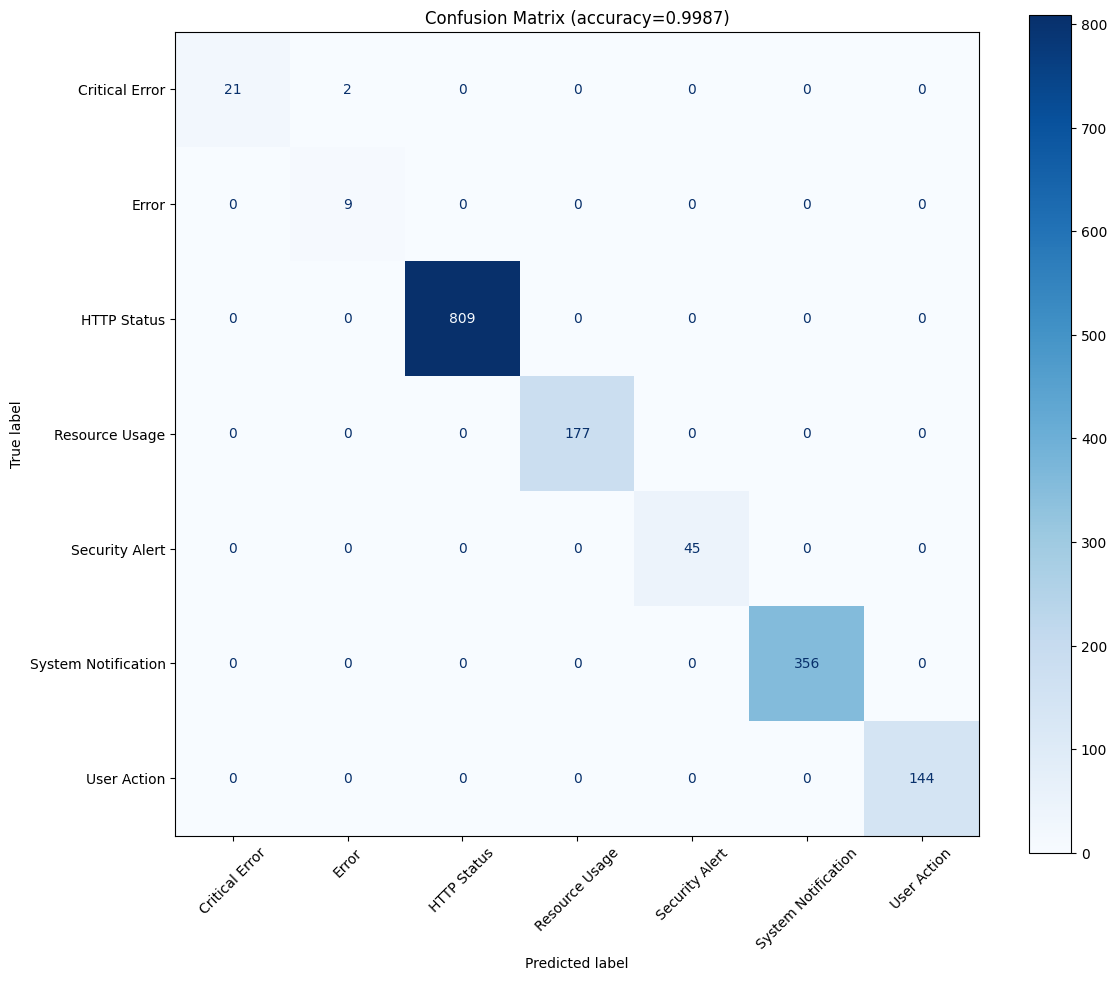

In [36]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import matplotlib.pyplot as plt

labels = sorted(set(y_true) | set(y_pred))
cm = confusion_matrix(y_true, y_pred, labels=labels)

fig, ax = plt.subplots(figsize=(12, 10))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(ax=ax, cmap='Blues', xticks_rotation=45, colorbar=True)
ax.set_title(f'Confusion Matrix (accuracy={acc:.4f})')
plt.tight_layout()
plt.show()

In [21]:
regex_unknown_df.head()

,timestamp,source,log_message,target_label,cluster,regex_labels
2,1/17/2025 1:29,AnalyticsEngine,Unauthorized access to data was attempted,Security Alert,2,Unknown
6,3/1/2025 19:14,ModernHR,Shard 6 replication task ended in failure,Error,3,Unknown
10,8/9/2025 18:58,ModernCRM,Email server encountered a sending fault,Error,1,Unknown
29,3/10/2025 23:11,AnalyticsEngine,Alert: brute force login attempt from 192.168....,Security Alert,12,Unknown
31,2025-10-28 00:49:44,ModernCRM,"nova.metadata.wsgi.server [-] 10.11.21.138,10....",HTTP Status,0,Unknown


In [22]:
regex_unknown_df["target_label"].value_counts()

target_label
Security Alert         326
HTTP Status            208
Error                  168
Critical Error         138
Workflow Error           4
Deprecation Warning      3
Name: count, dtype: int64

In [23]:
# Get value counts of target_label in regex_unknown_df
target_label_counts = regex_unknown_df['target_label'].value_counts()


labels_with_sufficient_count = target_label_counts[target_label_counts >= 10].index

# Create new dataframe with only those labels
filtered_df = regex_unknown_df[regex_unknown_df['target_label'].isin(labels_with_sufficient_count)].copy()

print(f"Original unknown df size: {len(regex_unknown_df)}")
print(f"Filtered df size: {len(filtered_df)}")
print(f"\nTarget label counts in filtered df:")
print(filtered_df['target_label'].value_counts())

Original unknown df size: 847
Filtered df size: 840

Target label counts in filtered df:
target_label
Security Alert    326
HTTP Status       208
Error             168
Critical Error    138
Name: count, dtype: int64


In [24]:
filtered_embeddings = model.encode(filtered_df['log_message'].tolist())
filtered_embeddings

array([[-0.00908223,  0.13003924, -0.05275566, ...,  0.02014104,
        -0.05117098, -0.02930296],
       [ 0.02246107, -0.08028954,  0.00877404, ..., -0.01508307,
        -0.00947432, -0.06809516],
       [ 0.04371333, -0.0067853 ,  0.08758412, ...,  0.05661772,
        -0.04497547, -0.05268193],
       ...,
       [ 0.07716464, -0.01395178, -0.02353957, ..., -0.0469558 ,
         0.02419546, -0.03593269],
       [-0.04022264,  0.0422436 , -0.06610421, ...,  0.0236367 ,
        -0.00530877,  0.0204446 ],
       [-0.03603452,  0.01960893,  0.10052755, ...,  0.03668106,
        -0.02487851, -0.00578846]], shape=(840, 384), dtype=float32)

In [25]:
from sklearn.linear_model import LogisticRegression

# Train logistic regression model on filtered embeddings
lr_model = LogisticRegression(max_iter=1000, random_state=42)
y_filtered = filtered_df['target_label']
lr_model.fit(filtered_embeddings, y_filtered)

# Check accuracy on training data
train_accuracy = lr_model.score(filtered_embeddings, y_filtered)
print(f"Training Accuracy: {train_accuracy:.4f} ({train_accuracy*100:.2f}%)")

Training Accuracy: 0.9952 (99.52%)


In [ ]:
# Predict on all embeddings
y_pred_all = lr_model.predict(embeddings)
y_pred_proba_all = lr_model.predict_proba(embeddings)

# Get the maximum probability for each prediction
max_proba_all = y_pred_proba_all.max(axis=1)

# Find predictions with probability <= 50%
low_confidence_mask_all = max_proba_all <= 0.5
low_confidence_count_all = low_confidence_mask_all.sum()

print(f"Number of predictions with probability <= 50%: {low_confidence_count_all}")
print(f"Total predictions: {len(y_pred_all)}")
print(f"Percentage: {(low_confidence_count_all / len(y_pred_all)) * 100:.2f}%")

In [31]:
from sklearn.metrics import accuracy_score, classification_report

y_pred_filtered = lr_model.predict(filtered_embeddings)
y_pred_proba = lr_model.predict_proba(filtered_embeddings)


max_proba = y_pred_proba.max(axis=1)

low_confidence_mask = max_proba <= 0.5
low_confidence_count = low_confidence_mask.sum()

In [33]:
print(f"Total predictions: {len(y_pred_filtered)}")
print(f"Percentage: {(low_confidence_count / len(y_pred_filtered)) * 100:.2f}%")

Total predictions: 840
Percentage: 0.48%


In [34]:
print("Classification Report:")
print(classification_report(y_filtered, y_pred_filtered, zero_division=0))

Classification Report:
                precision    recall  f1-score   support

Critical Error       0.98      0.99      0.99       138
         Error       1.00      0.98      0.99       168
   HTTP Status       1.00      1.00      1.00       208
Security Alert       1.00      1.00      1.00       326

      accuracy                           1.00       840
     macro avg       0.99      0.99      0.99       840
  weighted avg       1.00      1.00      1.00       840



In [28]:
import joblib

joblib.dump(lr_model, "../saved_models/lr_model.joblib")



['../saved_models/lr_model.joblib']